In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Conv1D, MaxPooling1D, Flatten, Input
from pyswarm import pso
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Charger les données
data = pd.read_excel('Generated_Data_Greenhouse_Cherry_Tomato.xlsx')

# Afficher les premières lignes du dataset
data.head()

,Time,Saison,Stage_de_croissance,Type_de_varieté,Température_de_l_air,Humidité_relative,Radiation_solaire,CO2_atmosphérique,Humidité_du_sol,Température_du_sol,...,Concentration_en_N,Concentration_en_P,Concentration_en_K,Prévisions_météorologiques,Durée_d_irrigation,Type_de_système_d_irrigation,Quantité_d_eau,Nutriment_N,Nutriment_P,Nutriment_K
0,2018-06-01 00:00:00,Été,germination,Tomate cerise,25.000000,68.083932,429.813162,398.908873,26.216610,22.494077,...,26.735292,21.688968,42.342760,nuageux,16,goutte à goutte,2.874013,6.858343,4.611286,11.218657
1,2018-06-01 00:05:00,Été,germination,Tomate cerise,25.000000,66.524076,432.826195,400.206785,27.008811,22.399602,...,34.670274,21.758783,46.246242,nuageux,17,goutte à goutte,3.009311,6.832058,3.628102,11.223244
2,2018-06-01 00:10:00,Été,germination,Tomate cerise,25.177915,66.948370,467.994262,395.600546,26.800195,22.390696,...,29.332990,20.894561,32.243490,nuageux,10,goutte à goutte,2.596737,6.383663,3.405576,11.133005
3,2018-06-01 00:15:00,Été,germination,Tomate cerise,25.272447,68.584728,470.159768,398.223308,27.055201,22.538412,...,29.244443,24.792805,35.664553,nuageux,11,goutte à goutte,2.610331,8.628377,4.284347,8.929208
4,2018-06-01 00:20:00,Été,germination,Tomate cerise,25.562752,69.711461,451.819924,397.170334,29.045756,22.651368,...,37.966568,18.632431,33.966812,nuageux,15,goutte à goutte,3.056676,8.393613,4.635265,9.806661


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525601 entries, 0 to 525600
Data columns (total 22 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Time                          525601 non-null  object 
 1   Saison                        525601 non-null  object 
 2   Stage_de_croissance           525601 non-null  object 
 3   Type_de_varieté               525601 non-null  object 
 4   Température_de_l_air          525601 non-null  float64
 5   Humidité_relative             525601 non-null  float64
 6   Radiation_solaire             525601 non-null  float64
 7   CO2_atmosphérique             525601 non-null  float64
 8   Humidité_du_sol               525601 non-null  float64
 9   Température_du_sol            525601 non-null  float64
 10  Conductivité_électrique       525601 non-null  float64
 11  pH_du_sol                     525601 non-null  float64
 12  Concentration_en_N            525601 non-nul

In [4]:
# Convert 'Time' column to datetime format
data['Time'] = pd.to_datetime(data['Time'])

# Set 'Time' column as the index
data.set_index('Time', inplace=True)

# Define aggregation functions for each column
aggregation_functions = {
    'Saison': 'first',
    'Stage_de_croissance': 'first',
    'Type_de_varieté': 'first',
    'Température_de_l_air': 'mean',
    'Humidité_relative': 'mean',
    'Radiation_solaire': 'mean',
    'CO2_atmosphérique': 'mean',
    'Prévisions_météorologiques': 'first',
    'Humidité_du_sol': 'mean',
    'Température_du_sol': 'mean',
    'Conductivité_électrique': 'mean',
    'pH_du_sol': 'mean',
    'Concentration_en_N': 'mean',
    'Concentration_en_P': 'mean',
    'Concentration_en_K': 'mean',
    'Type_de_système_d_irrigation': 'first',
    'Durée_d_irrigation' : 'sum',
    'Quantité_d_eau': 'sum',
    'Nutriment_N': 'sum',
    'Nutriment_P': 'sum',
    'Nutriment_K': 'sum'
}

# Resample the data to daily frequency and apply the aggregation functions
df_daily = data.resample('D').agg(aggregation_functions)

# Reset the index to turn 'Time' back into a column
df_daily.reset_index(inplace=True)
df_daily.head(5)

,Time,Saison,Stage_de_croissance,Type_de_varieté,Température_de_l_air,Humidité_relative,Radiation_solaire,CO2_atmosphérique,Prévisions_météorologiques,Humidité_du_sol,...,pH_du_sol,Concentration_en_N,Concentration_en_P,Concentration_en_K,Type_de_système_d_irrigation,Durée_d_irrigation,Quantité_d_eau,Nutriment_N,Nutriment_P,Nutriment_K
0,2018-06-01,Été,germination,Tomate cerise,28.912275,63.587948,502.199668,419.137688,nuageux,21.514117,...,6.427196,32.236739,20.597904,40.304200,goutte à goutte,4190,763.307346,2137.047679,1155.962107,2887.874966
1,2018-06-02,Été,germination,Tomate cerise,30.189057,61.811955,495.650294,405.259800,nuageux,24.108542,...,6.306384,32.850936,20.870337,39.458074,goutte à goutte,4274,749.750928,2143.220672,1145.644007,2927.925612
2,2018-06-03,Été,germination,Tomate cerise,28.725985,56.046777,393.377639,362.973715,nuageux,18.075755,...,6.758241,32.742524,20.996351,40.111620,goutte à goutte,4175,758.137859,2138.365216,1161.394322,2875.154454
3,2018-06-04,Été,germination,Tomate cerise,32.484033,57.627080,399.106426,359.287191,nuageux,20.088684,...,6.779564,32.279327,21.079825,40.666012,goutte à goutte,4184,740.263542,2168.204802,1164.348768,2857.570399
4,2018-06-05,Été,germination,Tomate cerise,27.442690,59.153252,556.979301,376.705795,nuageux,26.478048,...,6.618230,32.869658,21.039457,40.292490,goutte à goutte,4221,743.841051,2183.520167,1143.040715,2884.878194


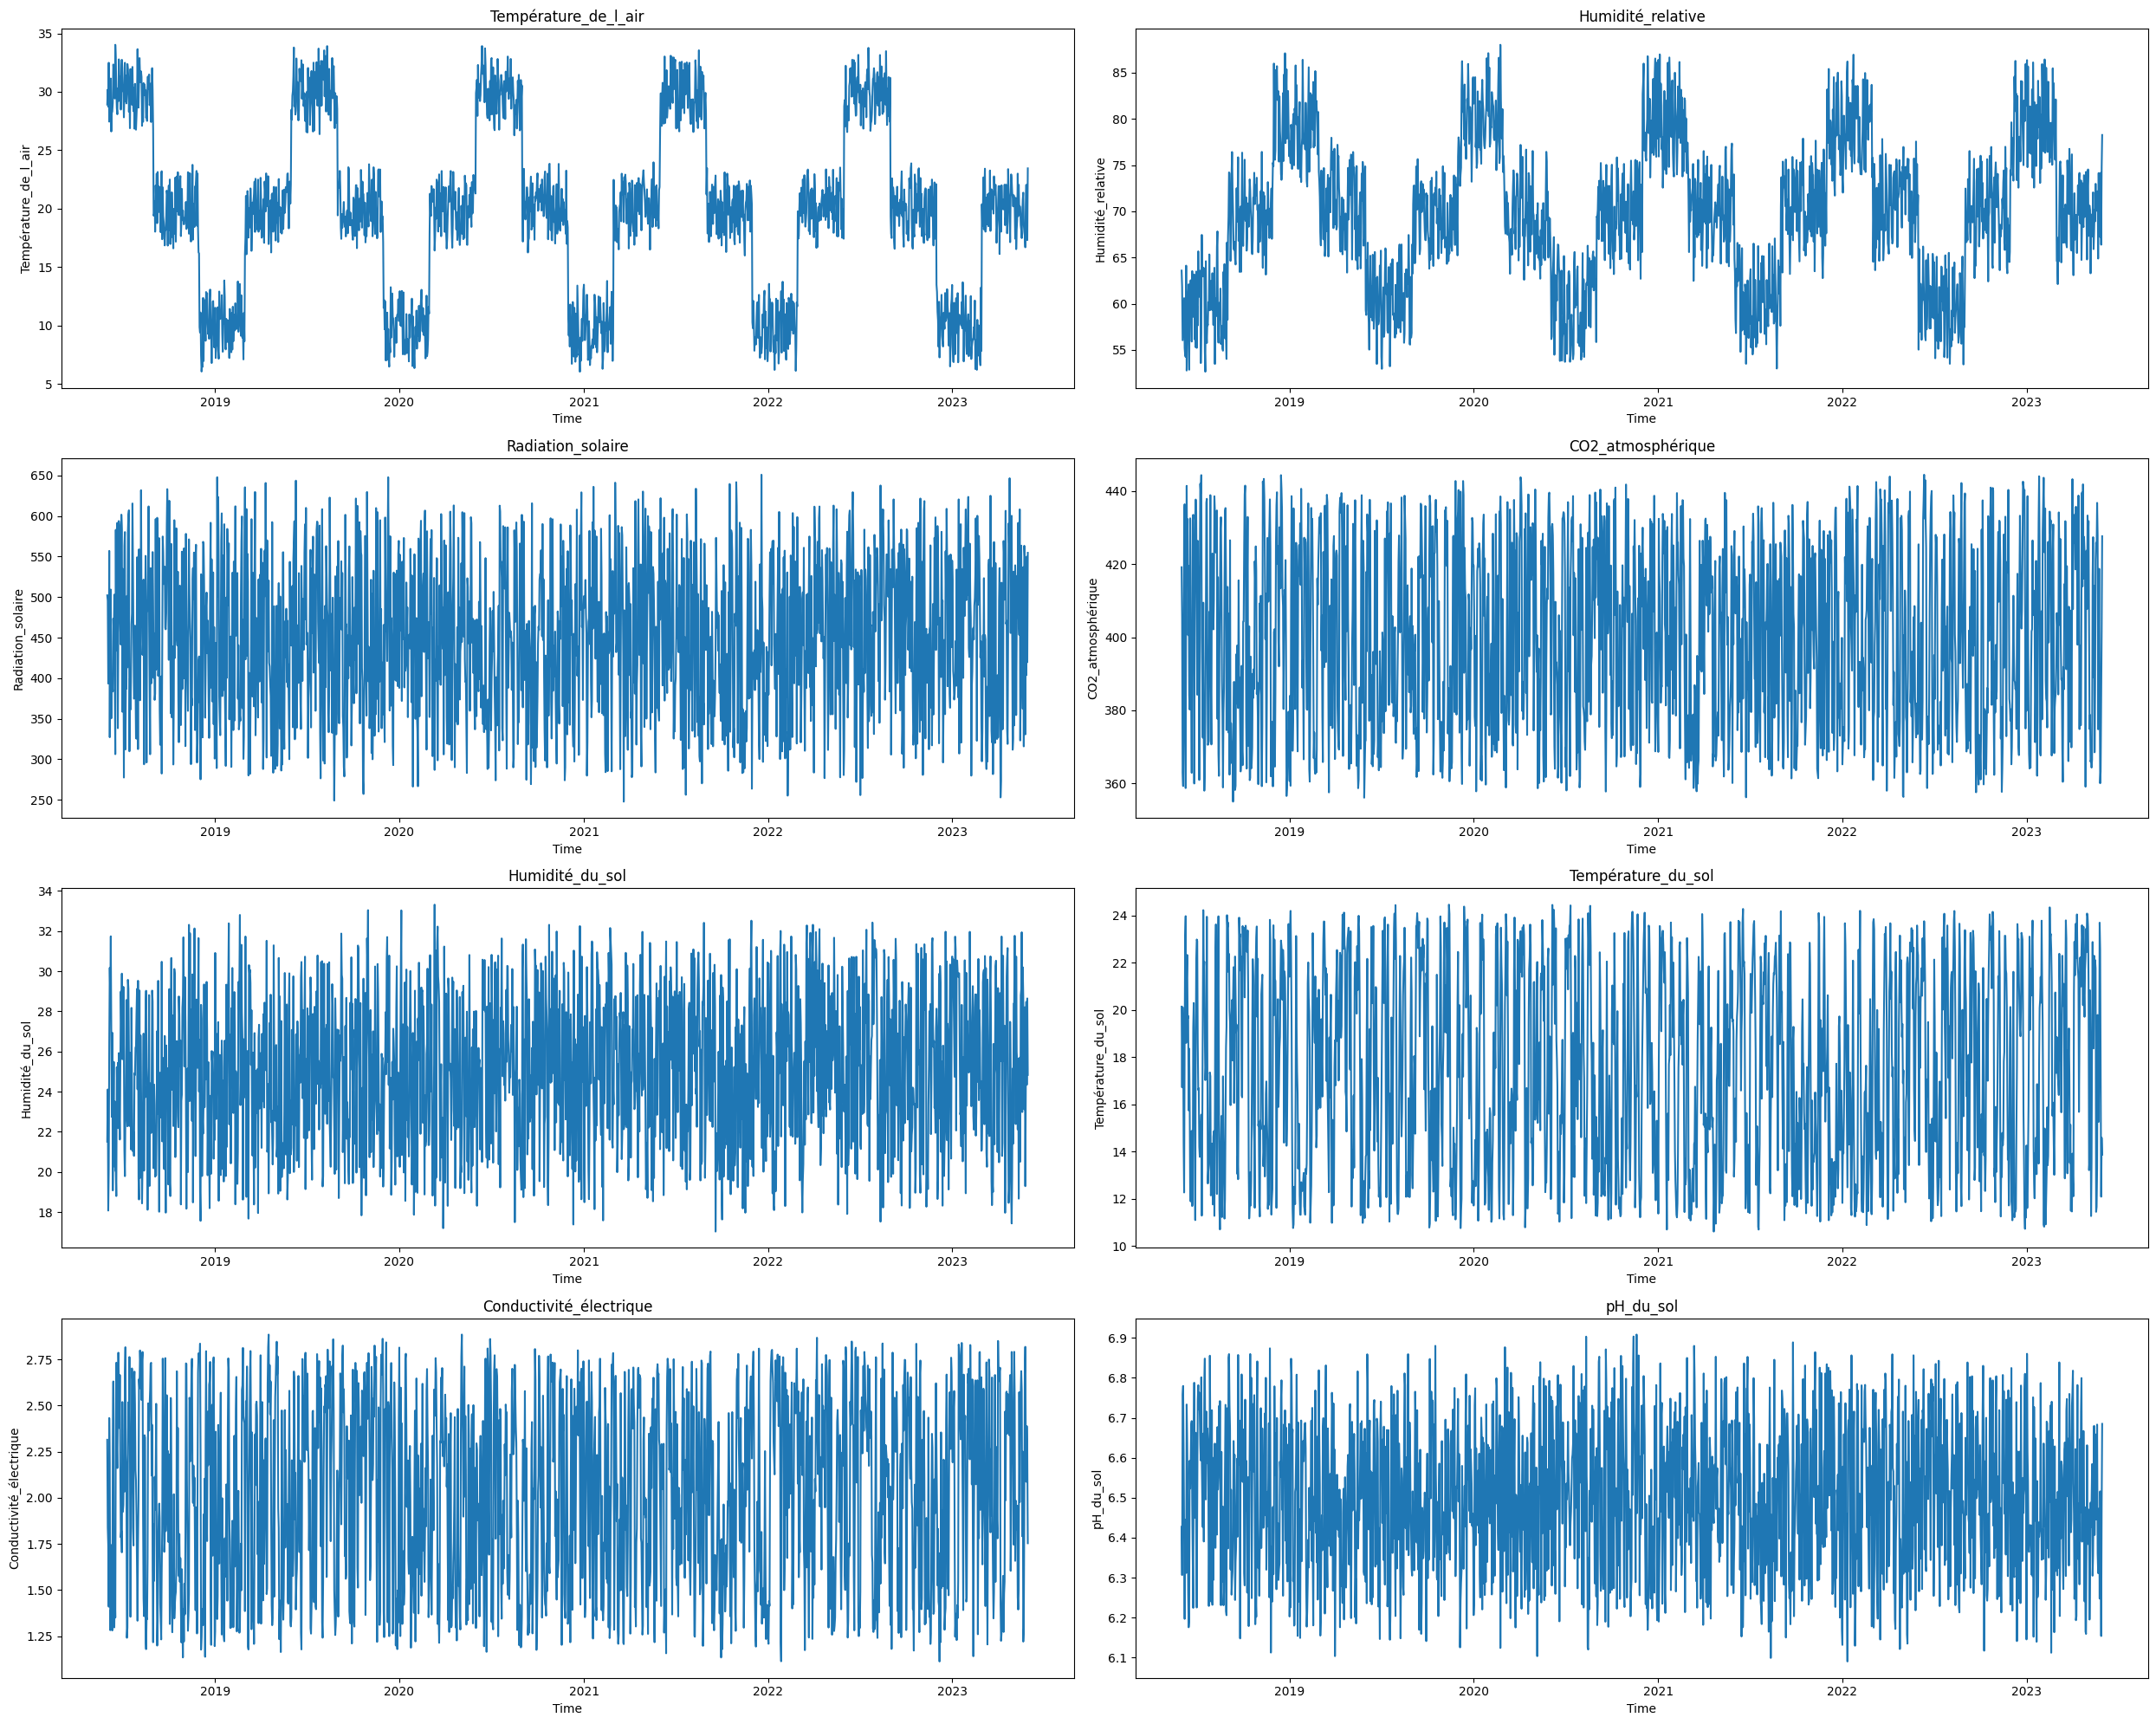

In [5]:
# Plot the time series for numerical features
numerical_features = [
    'Température_de_l_air', 'Humidité_relative', 'Radiation_solaire', 'CO2_atmosphérique',
    'Humidité_du_sol', 'Température_du_sol', 'Conductivité_électrique', 'pH_du_sol',
]

plt.figure(figsize=(25, 20))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(4, 2, i)
    plt.plot(df_daily['Time'], df_daily[feature])
    plt.title(feature)
    plt.xlabel('Time')
    plt.ylabel(feature)
    plt.tight_layout()

plt.show()

In [6]:
# Identifiez les colonnes de type 'object'
categorical_columns = df_daily.select_dtypes(include=['object']).columns

# Appliquez l'encodage one-hot
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_categories = encoder.fit_transform(df_daily[categorical_columns])

# Créez un DataFrame pour les colonnes encodées
encoded_df = pd.DataFrame(encoded_categories, columns=encoder.get_feature_names_out(categorical_columns))

# Combinez les colonnes encodées avec le DataFrame d'origine
df_encoded = pd.concat([df_daily.drop(columns=categorical_columns), encoded_df], axis=1)
df_encoded.head(5)  

,Time,Température_de_l_air,Humidité_relative,Radiation_solaire,CO2_atmosphérique,Humidité_du_sol,Température_du_sol,Conductivité_électrique,pH_du_sol,Concentration_en_N,...,Nutriment_P,Nutriment_K,Saison_Hiver,Saison_Printemps,Saison_Été,Stage_de_croissance_floraison,Stage_de_croissance_fructification,Stage_de_croissance_germination,Prévisions_météorologiques_nuageux,Prévisions_météorologiques_pluvieux
0,2018-06-01,28.912275,63.587948,502.199668,419.137688,21.514117,20.137757,2.314499,6.427196,32.236739,...,1155.962107,2887.874966,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,2018-06-02,30.189057,61.811955,495.650294,405.259800,24.108542,16.716931,1.839490,6.306384,32.850936,...,1145.644007,2927.925612,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,2018-06-03,28.725985,56.046777,393.377639,362.973715,18.075755,20.114216,1.740914,6.758241,32.742524,...,1161.394322,2875.154454,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,2018-06-04,32.484033,57.627080,399.106426,359.287191,20.088684,19.041287,1.409661,6.779564,32.279327,...,1164.348768,2857.570399,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4,2018-06-05,27.442690,59.153252,556.979301,376.705795,26.478048,14.352452,2.432022,6.618230,32.869658,...,1143.040715,2884.878194,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [7]:
# Normalization
scaler_features = MinMaxScaler()
scaler_targets = MinMaxScaler()

# Select the columns to normalize
feature_columns = df_encoded.drop(columns=['Quantité_d_eau', 'Nutriment_N', 'Nutriment_P', 'Nutriment_K', 'Time']).columns
target_columns = ['Quantité_d_eau', 'Nutriment_N', 'Nutriment_P', 'Nutriment_K']

# Normalize the features
df_encoded[feature_columns] = scaler_features.fit_transform(df_encoded[feature_columns])

# Normalize the targets
df_encoded[target_columns] = scaler_targets.fit_transform(df_encoded[target_columns])
df_encoded.head(5)

,Time,Température_de_l_air,Humidité_relative,Radiation_solaire,CO2_atmosphérique,Humidité_du_sol,Température_du_sol,Conductivité_électrique,pH_du_sol,Concentration_en_N,...,Nutriment_P,Nutriment_K,Saison_Hiver,Saison_Printemps,Saison_Été,Stage_de_croissance_floraison,Stage_de_croissance_fructification,Stage_de_croissance_germination,Prévisions_météorologiques_nuageux,Prévisions_météorologiques_pluvieux
0,2018-06-01,0.817449,0.309429,0.631073,0.717030,0.275324,0.687953,0.678232,0.411964,0.006727,...,0.979414,0.983866,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,2018-06-02,0.863071,0.259241,0.614827,0.561838,0.434574,0.441018,0.410191,0.264284,0.013653,...,0.970645,0.997563,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,2018-06-03,0.810792,0.096325,0.361138,0.088967,0.064272,0.686254,0.354566,0.816631,0.012431,...,0.984031,0.979515,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,2018-06-04,0.945076,0.140982,0.375348,0.047742,0.187829,0.608803,0.167646,0.842697,0.007207,...,0.986542,0.973501,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4,2018-06-05,0.764937,0.184110,0.766955,0.242528,0.580018,0.270336,0.744549,0.645482,0.013864,...,0.968432,0.982841,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


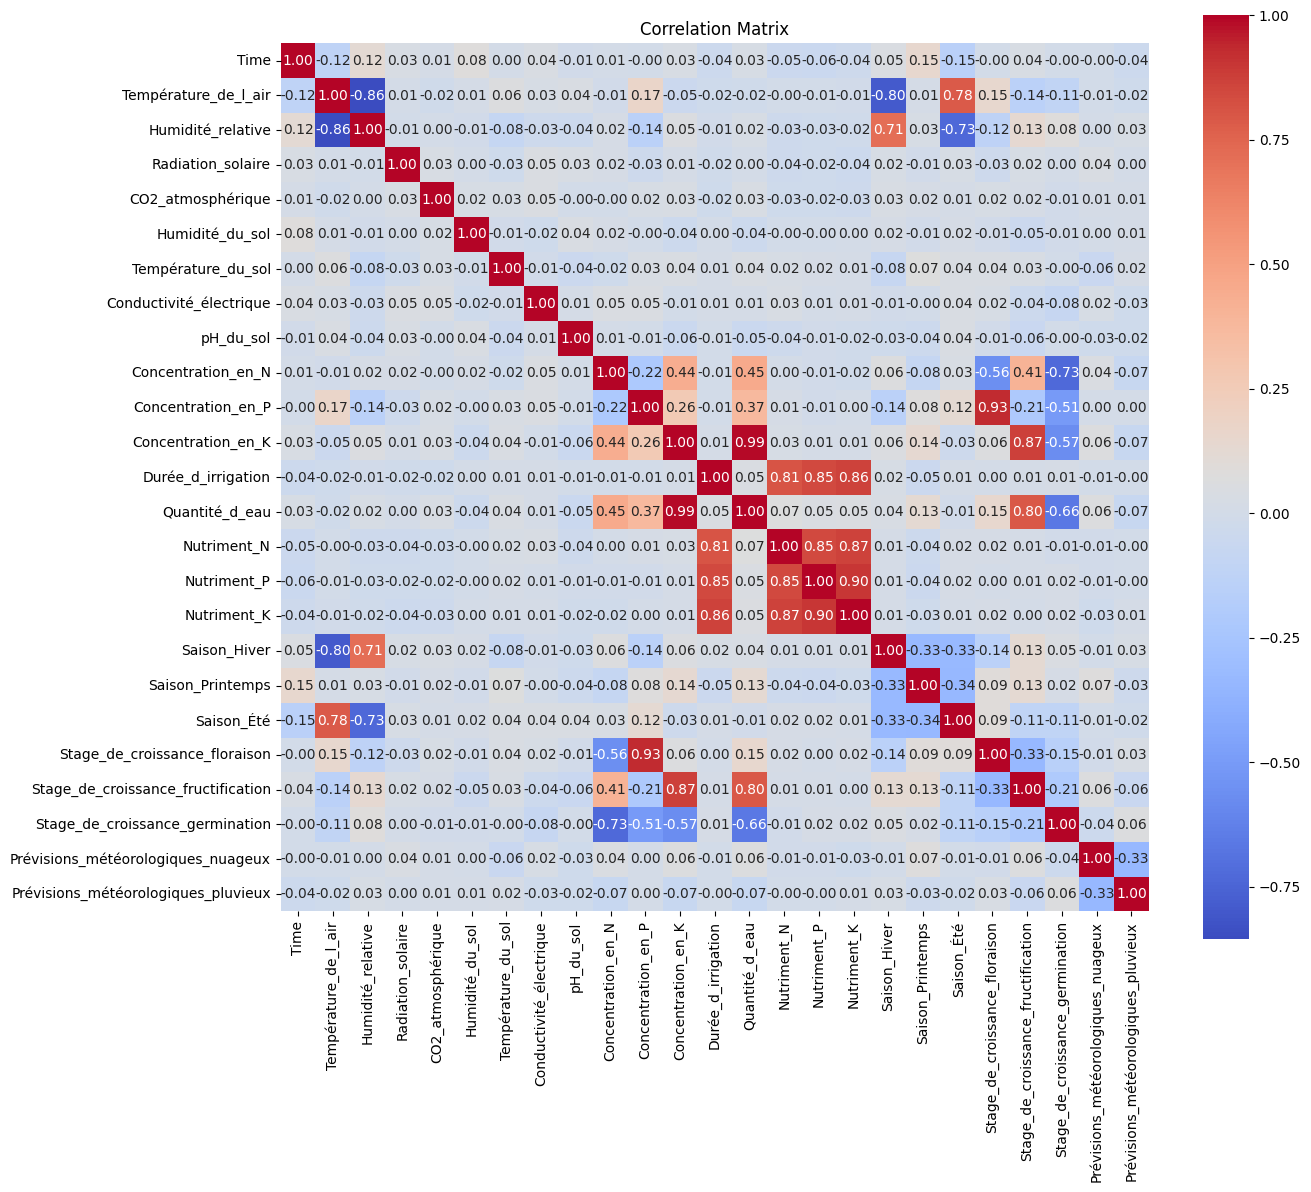

In [8]:
# Calculate the correlation matrix
correlation_matrix = df_encoded.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix')
plt.show()

In [9]:
# Delete the specified columns
columns_to_delete = ['Concentration_en_K', "Durée_d_irrigation"]
df_encoded = df_encoded.drop(columns=columns_to_delete)

In [10]:
# Fonction pour créer les séquences avec plusieurs jours de prédictions
def create_sequences(data, target, sequence_length, prediction_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length - prediction_length + 1):
        sequences.append(data[i:i+sequence_length])
        targets.append(target[i+sequence_length:i+sequence_length+prediction_length])
    return np.array(sequences), np.array(targets)

In [11]:
# Définir la longueur de la séquence et la longueur de la prédiction
sequence_length = 30  # Utiliser 30 jours de données pour prédire les valeurs futures
prediction_length = 8  # Prédire les 8 prochains jours

# Créer les séquences
features = df_encoded.drop(columns=target_columns + ['Time']).values
targets = df_encoded[target_columns].values
X, y = create_sequences(features, targets, sequence_length, prediction_length)

# Diviser les données en ensembles d'entraînement, de validation et de test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)